In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Business understanding

The main idea of analysis performed is revealing useful patterns and relationships which can be used for placing bets on UFC events.

In particular the following queations are addressed:
- What would be a simple strategy for betting?
- What factors influence fight result the most?
- How can fights not ending with decision be destinguished from others?

Answering these questions it is possible to find out what specific information should be considered when making a bet.

Process will involve:
- High level data structure exploration.
- Data cleaning and preparation.
- EDA and building model for answering questions posed.
- Analysing model performance.
- Reviewing results and making conclusions.

### Data understanding

Dataset being reviewed contains data about fights held by MMA promotion UFC. Each row represents a separate fight, including match-specific information such as winner and finish details, and also data about fighters: their rank, age, average takedown accuracy and so on.

Start with loading and reviewing the dataset.

In [587]:
df = pd.read_csv('./data/ufc-master.csv')

In [588]:
df.shape

(4307, 113)

In [589]:
df.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs
0,Robert Whittaker,Darren Till,-130,107,76.923077,107.000000,7/25/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0
1,Mauricio Rua,Rogerio Nogueira,-190,150,52.631579,150.000000,7/25/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Red,S-DEC,NaN,3.0,5:00,900.0
2,Fabricio Werdum,Alexander Gustafsson,260,-335,260.000000,29.850746,7/25/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Blue,SUB,Armbar,1.0,2:30,150.0
3,Carla Esparza,Marina Rodriguez,145,-182,145.000000,54.945055,7/25/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Red,S-DEC,NaN,3.0,5:00,900.0
4,Paul Craig,Gadzhimurad Antigulov,-137,110,72.992701,110.000000,7/25/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,neither,SUB,Triangle Choke,1.0,2:06,126.0


A bit of hight-level review.

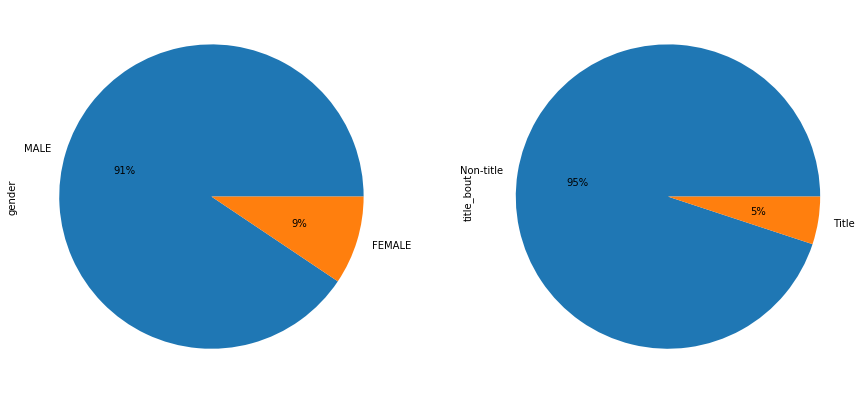

In [549]:
pylab.figure(figsize=(15, 7))
ax1 = plt.subplot(1, 2, 1)
df['gender'].value_counts().plot.pie(autopct='%1.0f%%')
ax1 = plt.subplot(1, 2, 2)
df['title_bout'].value_counts().plot.pie(labels=['Non-title', 'Title'], autopct='%1.0f%%')

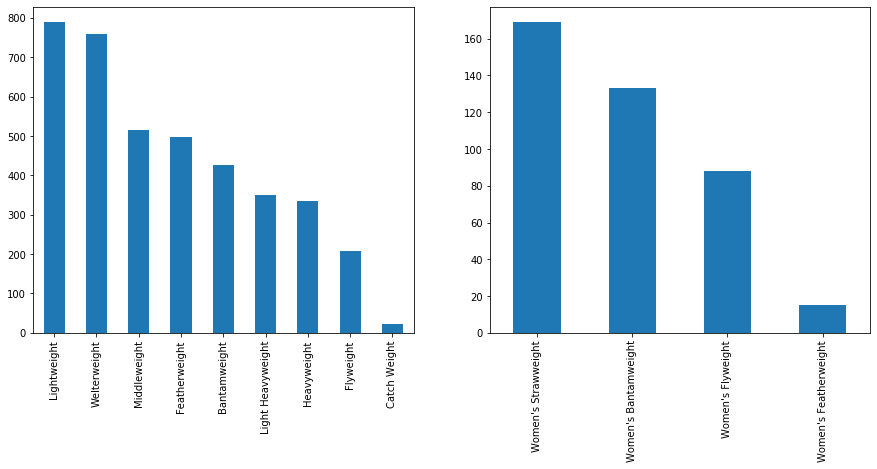

In [554]:
pylab.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
df[df['gender'] == 'MALE']['weight_class'].value_counts().plot(kind='bar')
ax1 = plt.subplot(1, 2, 2)
df[df['gender'] == 'FEMALE']['weight_class'].value_counts().plot(kind='bar')

Let's separate numeric and categorical variables, check amount of null values.
B_odds and R_odds values are strings, will convert those to int.

In [590]:
df[['B_odds', 'R_odds']] = df[['B_odds', 'R_odds']].astype(int)

In [591]:
cat_vars = df.select_dtypes(include=['object']).columns
num_vars = df.select_dtypes(exclude=['object']).columns
print("Dataset includes {0} numeric variables".format(len(num_vars)))
print("Dataset includes {0} categorical variables".format(len(cat_vars)))

Dataset includes 99 numeric variables
Dataset includes 14 categorical variables


In [592]:
print(df[num_vars].isna().sum().to_string())

R_odds                             0
B_odds                             0
R_ev                               0
B_ev                               0
title_bout                         0
no_of_rounds                       0
B_current_lose_streak              0
B_current_win_streak               0
B_draw                             0
B_avg_SIG_STR_landed             930
B_avg_SIG_STR_pct                765
B_avg_SUB_ATT                    832
B_avg_TD_landed                  833
B_avg_TD_pct                     842
B_longest_win_streak               0
B_losses                           0
B_total_rounds_fought              0
B_total_title_bouts                0
B_win_by_Decision_Majority         0
B_win_by_Decision_Split            0
B_win_by_Decision_Unanimous        0
B_win_by_KO/TKO                    0
B_win_by_Submission                0
B_win_by_TKO_Doctor_Stoppage       0
B_wins                             0
B_Height_cms                       0
B_Reach_cms                        0
B

In [593]:
print(df[cat_vars].isna().sum().to_string())

R_fighter               0
B_fighter               0
date                    0
location                0
country                 0
Winner                  0
weight_class            0
gender                  0
B_Stance                0
R_Stance                0
better_rank             0
finish                225
finish_details       2311
finish_round_time     225


Except for a set of variables which seem to be of the same type (ending with rank), data does not have a lot of missing values.

Assuming data B_ and R_ should be homogeneous, it is fair to see more or less same meand and std for them.

In [622]:
print("Average B strike accuracy is {0} with std {1}".format(df['B_avg_SIG_STR_pct'].mean(), df['B_avg_SIG_STR_pct'].std()))
print("Average R strike accuracy is {0} with std {1}".format(df['R_avg_SIG_STR_pct'].mean(), df['R_avg_SIG_STR_pct'].std()))
print("Average B takedown accuracy is {0} with std {1}".format(df['B_avg_TD_pct'].mean(), df['B_avg_TD_pct'].std()))
print("Average R takedown accuracy is {0} with std {1}".format(df['R_avg_TD_pct'].mean(), df['R_avg_TD_pct'].std()))
print("Average B total rounds fought: {0} with std {1}".format(df['B_total_rounds_fought'].mean(), df['B_total_rounds_fought'].std()))
print("Average R total rounds fought: {0} with std {1}".format(df['R_total_rounds_fought'].mean(), df['R_total_rounds_fought'].std()))
print("Average B wins: {0} with std {1}".format(df['B_wins'].mean(), df['B_wins'].std()))
print("Average R wins: {0} with std {1}".format(df['R_wins'].mean(), df['R_wins'].std()))
print("Average B age: {0} with std {1}".format(df['B_age'].mean(), df['B_age'].std()))
print("Average R age: {0} with std {1}".format(df['R_age'].mean(), df['R_age'].std()))

Average B strike accuracy is 0.4465254636592321 with std 0.11620971744106111
Average R strike accuracy is 0.4536037719620254 with std 0.10691974506734495
Average B takedown accuracy is 0.3081531674851366 with std 0.24420207381418696
Average R takedown accuracy is 0.32227470126954305 with std 0.2245983867810331
Average B total rounds fought: 10.483631297887161 with std 12.67652500151002
Average R total rounds fought: 15.420478291153936 with std 15.041555024983596
Average B wins: 2.799860691896912 with std 3.5287775829609553
Average R wins: 4.1492918504759695 with std 4.110667343097336
Average B age: 29.408637102391456 with std 3.9804678337503154
Average R age: 29.927791966566055 with std 4.092705986288325


Although overall fighters in Red corner tend to be more accurate and experienced.

In [624]:
print("Average strike per minute difference: {0} with std {1}".format(df['sig_str_dif'].mean(), df['sig_str_dif'].std()))
print("Average takedown attempts difference: {0} with std {1}".format(df['avg_td_dif'].mean(), df['avg_td_dif'].std()))
print("Average win difference: {0} with std {1}".format(df['win_dif'].mean(), df['win_dif'].std()))
print("Average rounds fought difference: {0} with std {1}".format(df['total_round_dif'].mean(), df['total_round_dif'].std()))
print("Average age difference: {0} with std {1}".format(df['age_dif'].mean(), df['age_dif'].std()))
print("Average reach difference: {0} with std {1}".format(df['reach_dif'].mean(), df['reach_dif'].std()))

Average strike per minute difference: -3.9767345134402134 with std 23.95814019010258
Average takedown attempts difference: -0.21893847429719043 with std 1.6337164539452185
Average win difference: -1.3494311585790573 with std 3.8740956754978724
Average rounds fought difference: -4.936846993266775 with std 15.21539743741181
Average age difference: 0.4671465056884142 with std 5.138221873381996
Average reach difference: -0.17347109356860937 with std 9.156726912439392


### Data preparation

First things first: starting with missing values handling. Getting back to set of columns having a lot of blanks. Some fighters used to fight in different weights than the current one, thus those also have their former ranks available. In order to keep it simple, I will drop those columns and only keep fight weight rank.

Match weight rank is also not available for all the fighters. Only top 15 are ranked, the lower the rank the better. We can not replace nan value with 0 here, so I will try to set it to a bigger value (20) and also add new column indicating that a fighter belongs to top 15.

In [483]:
df[['B_match_weightclass_rank', 'R_match_weightclass_rank']] = df[['B_match_weightclass_rank', 'R_match_weightclass_rank']].fillna(20)

In [484]:
df['B_is_in_top15'] = [1 if x < 20 else 0 for x in df['B_match_weightclass_rank']]
df['R_is_in_top15'] = [1 if x < 20 else 0 for x in df['R_match_weightclass_rank']]

Some rows have "finish_round" and "total_fight_time_secs" empty, which is weird. These rows also do not have any details about how match finished. I guess I will put zeroes here.

What we have left with NaNs are submissions and takedowns data which do not happen in all off the fights. Seems legit to replace missing values with 0 here.

In [485]:
df[num_vars] = df[num_vars].fillna(0)

Moving to categorica data. Firt I want to check amount of missing values as well.

In [486]:
df[cat_vars].isna().sum()

R_fighter               0
B_fighter               0
date                    0
location                0
country                 0
Winner                  0
weight_class            0
gender                  0
B_Stance                0
R_Stance                0
better_rank             0
finish                225
finish_details       2311
finish_round_time     225
dtype: int64

Same 225 missing values in "finish" and "finish_round_time". "finish_details" missing values seem to be quite legit. Most of the fights end with decision, and there is nothing more to say about it. 
I will fill missing values with constant string 'undefined' for "finish" and "finish_details". 

"finish_round_time" intuitively does not seem to belong to categorical. I want to convert it to single number (seconds) and use ans numeric variable.

In [487]:
df[['finish', 'finish_details']] = df[['finish', 'finish_details']].fillna('undefined')

In [578]:
def min_to_sec(s):
    """
    converts minutes+seconds to seconds
    Parameters:
    s(string): string i min:sec format
    Returns:
    int: single number of seconds
    """
    ss = str(s).split(':')
    return int(ss[0])*60 + int(ss[1])

df['finish_round_time'] = df['finish_round_time'].fillna('0:0')
df['finish_round_seconds'] = df['finish_round_time'].apply(min_to_sec)

I am not going to remove anything from the original dataset, but rather continie building 2 Index entities (num_vars and cat_vars) which I will use further during model building. 

It's pretty clear that fighters' names hardly influence results, so I will not include those. Same applies to location where the fights is held. 

I also want to convert "date" columns to datetime format for possible future usage during EDA or some auxilary manipulations. This column will not participate in model building.

In [489]:
df['date'] = pd.to_datetime(df['date'], yearfirst=True, format='%m/%d/%Y')

"gender" clearly can be boolean variable. I will also turn 'Winner' and 'better_rank' into boolean. 1 will be Blue, 0 - Red.

In [490]:
df['gender_bool'] = [1 if x == 'MALE' else 0 for x in df['gender']]
df['winner_bool'] = [1 if x == 'Blue' else 0 for x in df['Winner']]
df['better_rank_bool'] = [1 if x == 'Blue' else 0 for x in df['better_rank']]

In [491]:
cat_vars = pd.Index(['country', 'weight_class', 'B_Stance', 'R_Stance', 'better_rank', 
                     'finish', 'finish_details'])

In [492]:
num_vars = pd.Index(['R_odds', 'B_odds', 'R_ev', 'B_ev', 'title_bout', 'no_of_rounds',
       'B_current_lose_streak', 'B_current_win_streak', 'B_draw',
       'B_avg_SIG_STR_landed', 'B_avg_SIG_STR_pct', 'B_avg_SUB_ATT',
       'B_avg_TD_landed', 'B_avg_TD_pct', 'B_longest_win_streak', 'B_losses',
       'B_total_rounds_fought', 'B_total_title_bouts',
       'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
       'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Height_cms', 'B_Reach_cms',
       'B_Weight_lbs', 'R_current_lose_streak', 'R_current_win_streak',
       'R_draw', 'R_avg_SIG_STR_landed', 'R_avg_SIG_STR_pct', 'R_avg_SUB_ATT',
       'R_avg_TD_landed', 'R_avg_TD_pct', 'R_longest_win_streak', 'R_losses',
       'R_total_rounds_fought', 'R_total_title_bouts',
       'R_win_by_Decision_Majority', 'R_win_by_Decision_Split',
       'R_win_by_Decision_Unanimous', 'R_win_by_KO/TKO', 'R_win_by_Submission',
       'R_win_by_TKO_Doctor_Stoppage', 'R_wins', 'R_Height_cms', 'R_Reach_cms',
       'R_Weight_lbs', 'R_age', 'B_age', 'lose_streak_dif', 'win_streak_dif',
       'longest_win_streak_dif', 'win_dif', 'loss_dif', 'total_round_dif',
       'total_title_bout_dif', 'ko_dif', 'sub_dif', 'height_dif', 'reach_dif',
       'age_dif', 'sig_str_dif', 'avg_sub_att_dif', 'avg_td_dif',
       'empty_arena', 'finish_round', 'total_fight_time_secs', 'B_is_in_top15', 
        'R_is_in_top15', 'finish_round_seconds', 'gender_bool', 
        'better_rank_bool'])

In [493]:
df[cat_vars].head()

,country,weight_class,B_Stance,R_Stance,better_rank,finish,finish_details
0,United Arab Emirates,Middleweight,Southpaw,Orthodox,Red,U-DEC,undefined
1,United Arab Emirates,Light Heavyweight,Southpaw,Orthodox,Red,S-DEC,undefined
2,United Arab Emirates,Heavyweight,Orthodox,Orthodox,Blue,SUB,Armbar
3,United Arab Emirates,Women's Strawweight,Orthodox,Orthodox,Red,S-DEC,undefined
4,United Arab Emirates,Light Heavyweight,Orthodox,Orthodox,neither,SUB,Triangle Choke


In [494]:
for ind in cat_vars:
    print(ind)
    print(df[ind].value_counts())

country
 USA                     2450
 Brazil                   400
 Canada                   337
 United Kingdom           165
 Australia                160
USA                       100
 Sweden                    72
 Mexico                    70
 China                     61
 Germany                   54
 Japan                     53
United Arab Emirates       51
 Singapore                 45
 Russia                    36
 New Zealand               33
 United Arab Emirates      29
 Netherlands               25
 South Korea               24
 Poland                    23
 Ireland                   19
 Croatia                   13
 Czech Republic            13
 Uruguay                   13
 Denmark                   13
 Chile                     13
 Argentina                 12
 Philippines               12
Brazil                     11
Name: country, dtype: int64
weight_class
Lightweight              789
Welterweight             759
Middleweight             516
Featherweight           

Some country names have leading whitespace, need to clean this up.

In [495]:
df['country'] = df['country'].apply(lambda x: str(x).strip())

All columns seem to have reasonably low cardinality, so we can apply One Hot encoding (or dummy variables) when building the model.

## IT'S TIME  (in Bruce Buffer's voice)##

I will start my analysis trying to answer the following question: 

### What would be a simple strategy for betting?

Do I have to look for something complicated or is there something straighforward?

In [496]:
df_ranked = df[df['better_rank'] != 'neither']
print("Better ranked fighter wins in {:.2f}% of fights".format(df_ranked[df_ranked['better_rank'] == df_ranked['Winner']].shape[0]/df_ranked.shape[0]*100))

Better ranked fighter wins in 61.08% of fights


Main card mostly consists of the matches where at least one of the fighters is in top-15, so this is something. Still, this is only a small part.

In [497]:
print("{:.2f}% of fights".format(df_ranked.shape[0]/df.shape[0]*100))

27.98% of fights


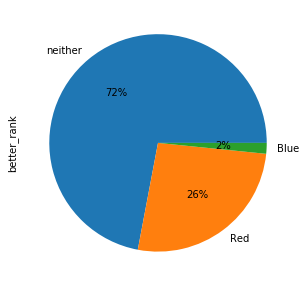

In [559]:
pylab.figure(figsize=(5, 5))
df['better_rank'].value_counts().plot.pie(autopct='%1.0f%%')

But we were talking about money and see if I can bet UFC fight results with some profit. What if I always keep the same strategy? Say, always bet the guy having more wins in past will win? I can hardly imagine myself betting for 10 years, so let's take 2019 and 2020 only.

In [498]:
df_19_20 = df[df['date']>='2019-01-01']
bet_win = [(x['B_ev']+100)*x['winner_bool'] if x['win_dif'] > 0 else (x['R_ev']+100)*(1-x['winner_bool']) for _, x in df_19_20.iterrows()]
print("{:.2f} USD".format(np.sum(bet_win)-100*df_19_20.shape[0]))

-4260.27 USD


Alright, going with this strategy I would lose 4k in less than 2 years. Does not look like a success story for me.

Maybe the older fighter?

In [499]:
bet_win = [(x['B_ev']+100)*x['winner_bool'] if x['age_dif'] > 0 else (x['R_ev']+100)*(1-x['winner_bool']) for _, x in df_19_20.iterrows()]
print("{:.2f} USD".format(np.sum(bet_win)-100*df_19_20.shape[0]))

-2130.51 USD


Maybe the one showing greater average amount of significant strikes?

In [500]:
bet_win = [(x['B_ev']+100)*x['winner_bool'] if x['sig_str_dif'] > 0 else (x['R_ev']+100)*(1-x['winner_bool']) for _, x in df_19_20.iterrows()]
print("{:.2f} USD".format(np.sum(bet_win)-100*df_19_20.shape[0]))

3615.10 USD


Finally something! Won't make me a millionaire, but better than losing money.

In [501]:
cols = ['win_dif', 'age_dif', 'sig_str_dif', 'reach_dif', 'height_dif', 'total_round_dif', 
        'avg_td_dif']
for col in cols:
    bet_win = [(x['B_ev']+100)*x['winner_bool'] if x[col] > 0 else (x['R_ev']+100)*(1-x['winner_bool']) for _, x in df_19_20.iterrows()]
    print("{}: {:.2f} USD".format(col, np.sum(bet_win)-100*df_19_20.shape[0]))

win_dif: -4260.27 USD
age_dif: -2130.51 USD
sig_str_dif: 3615.10 USD
reach_dif: -2174.17 USD
height_dif: 1480.89 USD
total_round_dif: -1597.05 USD
avg_td_dif: -11.06 USD


The only ones leaving me in plus are: the fighter having more win and the taller one.

Alright, but what does affect the match result in the end? Instead of making guesses let me build the model answering the question:

### What factors influence fight result the most?

Task can be treated as binary classification. In the dataframe we always have data available in fixed order: first it's fighter in the blue corner, then - in the right. Target varible 'winner_bool' is 1 if Blue wins, 0 - if Right. Thus B_ columns can be treated as 'fighter data', and R_ columns - as 'opponent data' and we want to know whether the fighter wins or not.

Some of the variables should be removed before building the model. If we want to predict result of the match, we can not use information about whether the match finished with decision or submission and in which round it finished. Numeric values also should be stardatized, categorical values should be encoded.

In [502]:
cat_vars = pd.Index(['weight_class', 'B_Stance', 'R_Stance', 'better_rank'])
num_vars_no_finish = num_vars.drop(['finish_round', 'total_fight_time_secs', 'finish_round_seconds'])

In [503]:
X = pd.get_dummies(df[cat_vars])
X = pd.concat([df[num_vars_no_finish], X], axis=1)
y = df['winner_bool']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [504]:
scaler = MinMaxScaler()
#X_train.loc[:, num_vars] = scaler.fit_transform(X_train[num_vars])
#X_test.loc[:, num_vars] = scaler.transform(X_test[num_vars])
X = scaler.fit_transform(X)

We can now build simple Logistic Regression model. Instead of splitting into train and test sets I will use k-fold cross-validation strategy with 3 folds.

In [505]:
log_reg = LogisticRegression()
#log_reg.fit(X_train, y_train)
#y_pred = log_reg.predict(X_test)
#print(accuracy_score(y_test, y_pred))
cross_val_score(log_reg, X, y, cv=3).mean()

0.6491769627206817

This does not seem to give too good accuracy. Regression is not the only model we can build. I also want to try Random Forest and Gradient Boosting.

In [506]:
gb_clf = GradientBoostingClassifier()
#gb_clf.fit(X_train, y_train)
#y_pred = gb_clf.predict(X_test)
#print(accuracy_score(y_test, y_pred))
cross_val_score(gb_clf, X, y, cv=3).mean()

0.6484809074115413

In [507]:
rf_clf = RandomForestClassifier()
#rf_clf.fit(X_train, y_train)
#y_pred = rf_clf.predict(X_test)
#print(accuracy_score(y_test, y_pred))
cross_val_score(rf_clf, X, y, cv=3).mean()

0.653588332540707

I tried tuning some hyperparameters here, which made no significant improvements, so I will stick to default values. Looks like without additional precessing and maybe feature engineering this is the maximum we can get.

Even so, I want to check which columns make the most contribution.

In [582]:
def train_model(df, y, cat_vars, num_vars, model):
    """
    encodes cat_vars, scales num_vars, performs train-test split, trains model
    Parameters:
    df (DataFrame): dataframe to work with
    y (Series): target variable
    cat_cars (Index): categorical variables
    num_vars (Index): numeric variables
    model (LogisticRegression): model to train, used to predict and get coefficients
    Returns:
    (ndarray): model coefficients 
    (Index): dataframe columns
    """
    X = pd.get_dummies(df[cat_vars])
    X = pd.concat([df[num_vars], X], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    scaler = MinMaxScaler()
    X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
    X_test[num_vars] = scaler.transform(X_test[num_vars])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    print(accuracy_score(y_test, y_pred))
    return model.coef_[0], X_train.columns

In [583]:
def get_coef(model_coef, df_columns):
    """
    builds dataframe containing model coefficients for dataframe columns
    Parameters:
    model_coef (ndarray): model coefficients 
    df_columns (Index): dataframe columns
    Returns:
    (DataFrame): dataframe containing model coefficients
    """
    coef_df = pd.DataFrame()
    coef_df['column'] = df_columns
    coef_df['coef'] = model_coef
    coef_df['abs_coefs'] = np.abs(model_coef)
    coef_df = coef_df.sort_values('abs_coefs', ascending=False)
    return coef_df

In [575]:
log_reg_coef, X_columns = train_model(df, y, cat_vars, num_vars_no_finish, LogisticRegression())
coef_df = get_coef(log_reg_coef, X_columns)
coef_df.head(10)

0.6573859242072699


,column,coef,abs_coefs
3,B_ev,-2.859339,2.859339
2,R_ev,1.853018,1.853018
27,B_Weight_lbs,1.044854,1.044854
0,R_odds,1.016001,1.016001
41,R_win_by_Decision_Split,0.957630,0.957630
34,R_avg_TD_landed,-0.877462,0.877462
20,B_win_by_Decision_Unanimous,0.865644,0.865644
1,B_odds,-0.823372,0.823372
69,R_is_in_top15,0.739697,0.739697
7,B_current_win_streak,0.722225,0.722225


What a surprise (no)! Most meaningful variables turn out to be the ones related to odds. 

Interenting enough. If we set logistic regression to use L1 penalty which eliminates features rather that optimizes coefficients, it removes "_odd" features.

In [511]:
log_reg_coef, X_columns = train_model(df, y, cat_vars, num_vars_no_finish, 
                           LogisticRegression(solver='liblinear', penalty='l1'))
coef_df = get_coef(log_reg_coef, X_columns)
coef_df.head(10)

0.6674400618716164


,column,coef,abs_coefs
3,B_ev,-4.743403,4.743403
2,R_ev,2.346800,2.346800
34,R_avg_TD_landed,-1.015773,1.015773
27,B_Weight_lbs,0.904625,0.904625
41,R_win_by_Decision_Split,0.874491,0.874491
14,B_longest_win_streak,-0.748248,0.748248
20,B_win_by_Decision_Unanimous,0.651671,0.651671
7,B_current_win_streak,0.620571,0.620571
51,B_age,-0.592524,0.592524
95,better_rank_Red,-0.525218,0.525218


Which of course makes sense. There is strong connection between ev and odd features. It we calculate correlation (I use Spearman correlation here as it is reasonable to assume relation is monotonous, not necessarily linear), we can clearly see its absolute value is very close to 1.

In [512]:
df[['B_ev', 'R_ev', 'B_odds', 'R_odds']].corr(method='spearman')

,B_ev,R_ev,B_odds,R_odds
B_ev,1.000000,-0.998422,0.999973,-0.998386
R_ev,-0.998422,1.000000,-0.998391,0.999963
B_odds,0.999973,-0.998391,1.000000,-0.998415
R_odds,-0.998386,0.999963,-0.998415,1.000000


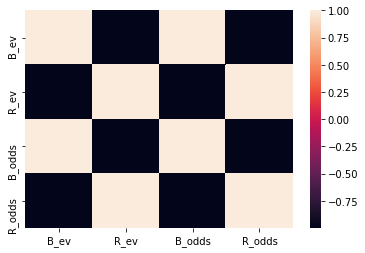

In [576]:
sns.heatmap(df[['B_ev', 'R_ev', 'B_odds', 'R_odds']].corr(method='spearman'))

Assuming strong correlation between all 4, we can only leave one of these in the model.

In [513]:
num_vars_no_ev = num_vars_no_finish.drop(['R_odds', 'B_ev', 'R_ev'])
log_reg_coef, X_columns = train_model(df, y, cat_vars, num_vars_no_ev, LogisticRegression())
coef_df = get_coef(log_reg_coef, X_columns)
coef_df.head(10)

0.6473317865429234


,column,coef,abs_coefs
0,B_odds,-5.191321,5.191321
24,B_Weight_lbs,1.061197,1.061197
38,R_win_by_Decision_Split,0.997265,0.997265
31,R_avg_TD_landed,-0.884667,0.884667
17,B_win_by_Decision_Unanimous,0.878113,0.878113
66,R_is_in_top15,0.792749,0.792749
4,B_current_win_streak,0.687705,0.687705
11,B_longest_win_streak,-0.654430,0.654430
19,B_win_by_Submission,0.641261,0.641261
27,R_draw,-0.632806,0.632806


Accuracy is almost the same. If we remove the odds data completely, here is what we get.

In [514]:
num_vars_no_odds = num_vars_no_ev.drop(['B_odds'])
log_reg_coef, X_columns = train_model(df, y, cat_vars, num_vars_no_odds, LogisticRegression())
coef_df = get_coef(log_reg_coef, X_columns)
coef_df.head(10)

0.6017014694508894


,column,coef,abs_coefs
33,R_losses,1.288390,1.288390
37,R_win_by_Decision_Split,1.241584,1.241584
30,R_avg_TD_landed,-1.192475,1.192475
23,B_Weight_lbs,1.156981,1.156981
47,B_age,-1.062213,1.062213
45,R_Weight_lbs,-0.897206,0.897206
16,B_win_by_Decision_Unanimous,0.876509,0.876509
3,B_current_win_streak,0.867978,0.867978
65,R_is_in_top15,0.846938,0.846938
46,R_age,0.841692,0.841692


Low enough accuracy goes even lower.

Conclusion is simple here. Odds do not come from nowhere and you probably want to take those into consideration. Still, let me check, how much I can earn always betting the fighter with better odds.

In [515]:
bet_win = [(x['B_ev']+100)*x['winner_bool'] if x['B_odds'] < 0 else (x['R_ev']+100)*(1-x['winner_bool']) for _, x in df_19_20.iterrows()]
print("{:.2f} USD".format(np.sum(bet_win)-100*df_19_20.shape[0]))

-3937.50 USD


Let me change train-test split a bit. I want my model to fit on data prior to 2019 and use it's predictions for later fights. I will check the accuracy and amount of money I can earn on bets.

In [516]:
X = pd.get_dummies(df[cat_vars])
X = pd.concat([df[num_vars_no_finish], X], axis=1)
X['winner_bool'] = df['winner_bool']
X_train = X[df['date']<'2019-01-01']
X_test = X[df['date']>='2019-01-01']
y_train = X_train['winner_bool']
X_train = X_train.drop(['winner_bool'], axis=1)
y_test = X_test['winner_bool']
X_test = X_test.drop(['winner_bool'], axis=1)
scaler = MinMaxScaler()
X_train[num_vars_no_finish] = scaler.fit_transform(X_train[num_vars_no_finish])
X_test[['B_ev_orig', 'R_ev_orig']] = X_test[['B_ev', 'R_ev']] 
X_test[num_vars_no_finish] = scaler.transform(X_test[num_vars_no_finish])
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test.drop(['B_ev_orig', 'R_ev_orig'], axis=1))
print(accuracy_score(y_test, y_pred))

0.6383265856950068


In [517]:
X_test['winner_pred'] = y_pred
X_test['winner_bool'] = y_test

In [518]:
bet_win = [(x['B_ev_orig']+100)*x['winner_bool'] if x['winner_pred'] else (x['R_ev_orig']+100)*(1-x['winner_bool']) for _, x in X_test.iterrows()]
print("{:.2f} USD".format(np.sum(bet_win)-100*df_19_20.shape[0]))

-1036.58 USD


Surprised? Bad result is also a result. I am quite sure we CAN build good enough model in the end with some feature selection, feature engineering and hyperparameter tuning, but there is no simple one minute solution for this. What you always can do is enjoy a spectacular fight.

Speaking of which. I am not a fan of bouts ending with decision. I love knockounts and submission. Which leads me to the next question.

### Is there anything special about fights not ending with decision?

Here I want to start with some EDA and visualising.

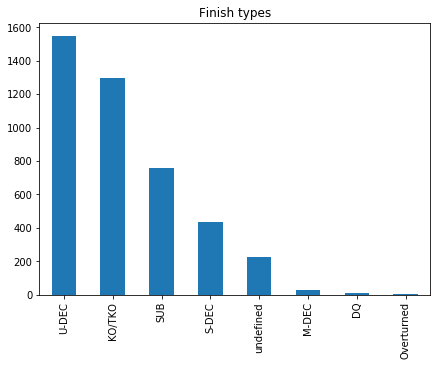

In [577]:
pylab.figure(figsize=(7, 5))
plt.title('Finish types')
df['finish'].value_counts().plot(kind='bar')

My goal is to distinguish fights ending before decision. I will create new boolean colum identifyng this. Undefined finish, disqualification and overturned fights make no interest here, I will remove data about those fights.

In [520]:
df_finish = df[~df.finish.isin(['undefined', 'DQ', 'Overturned'])]
df_finish['ended_before_decision'] = [1 if x in['KO/TKO', 'SUB'] else 0 for x in df_finish['finish']]

So, how can I distunguish 'interesting' fights? I am going to check if the distibution of sifferent features differs for 2 types of fights.

In [521]:
print("Percentage of KO/TKO/SUB fights among title bouts: {:.2f}%".format(df_finish[df_finish['title_bout']][df_finish['ended_before_decision'] == 1].shape[0]/df_finish[df_finish['title_bout']].shape[0]*100))
print("Percentage of KO/TKO/SUB fights among non-title bouts: {:.2f}%".format(df_finish[~df_finish['title_bout']][df_finish['ended_before_decision'] == 1].shape[0]/df_finish[~df_finish['title_bout']].shape[0]*100))

Percentage of KO/TKO/SUB fights among title bouts: 55.56%
Percentage of KO/TKO/SUB fights among non-title bouts: 50.27%


In [522]:
print("Percentage of KO/TKO/SUB fights among men bouts: {:.2f}%".format(df_finish[df_finish['gender_bool'] == 1][df_finish['ended_before_decision'] == 1].shape[0]/df_finish[df_finish['gender_bool'] == 1].shape[0]*100))
print("Percentage of KO/TKO/SUB fights among women bouts: {:.2f}%".format(df_finish[df_finish['gender_bool'] == 0][df_finish['ended_before_decision'] == 1].shape[0]/df_finish[df_finish['gender_bool'] == 0].shape[0]*100))

Percentage of KO/TKO/SUB fights among men bouts: 51.83%
Percentage of KO/TKO/SUB fights among women bouts: 37.74%


Title and non-title bouts seem to have same distribution. Women tend to have decision ending fights.

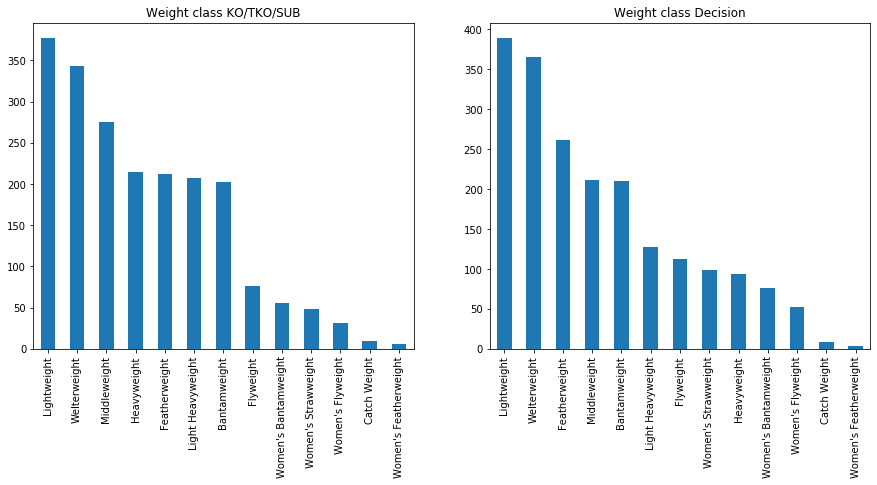

In [523]:
pylab.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title('Weight class KO/TKO/SUB')
df_finish['weight_class'][df_finish['ended_before_decision'] == 1].value_counts().plot(kind='bar')
ax1 = plt.subplot(1, 2, 2)
plt.title('Weight class Decision')
df_finish['weight_class'][df_finish['ended_before_decision'] == 0].value_counts().plot(kind='bar')

Weight class distribution reflects overall picture: Lightweight looks more popular thatn others (my favourite btw). No significant difference between 2 plots.

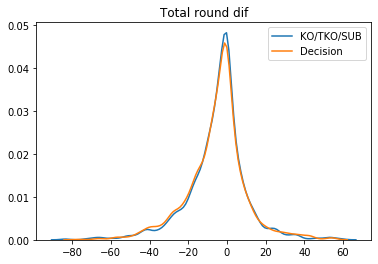

In [524]:
plt.title('Total round dif')
sns.kdeplot(df_finish['total_round_dif'][df_finish['ended_before_decision'] == 1], 
            label='KO/TKO/SUB')
sns.kdeplot(df_finish['total_round_dif'][df_finish['ended_before_decision'] == 0], 
            label='Decision')

Alright, let me just plot all reasonable numeric values.

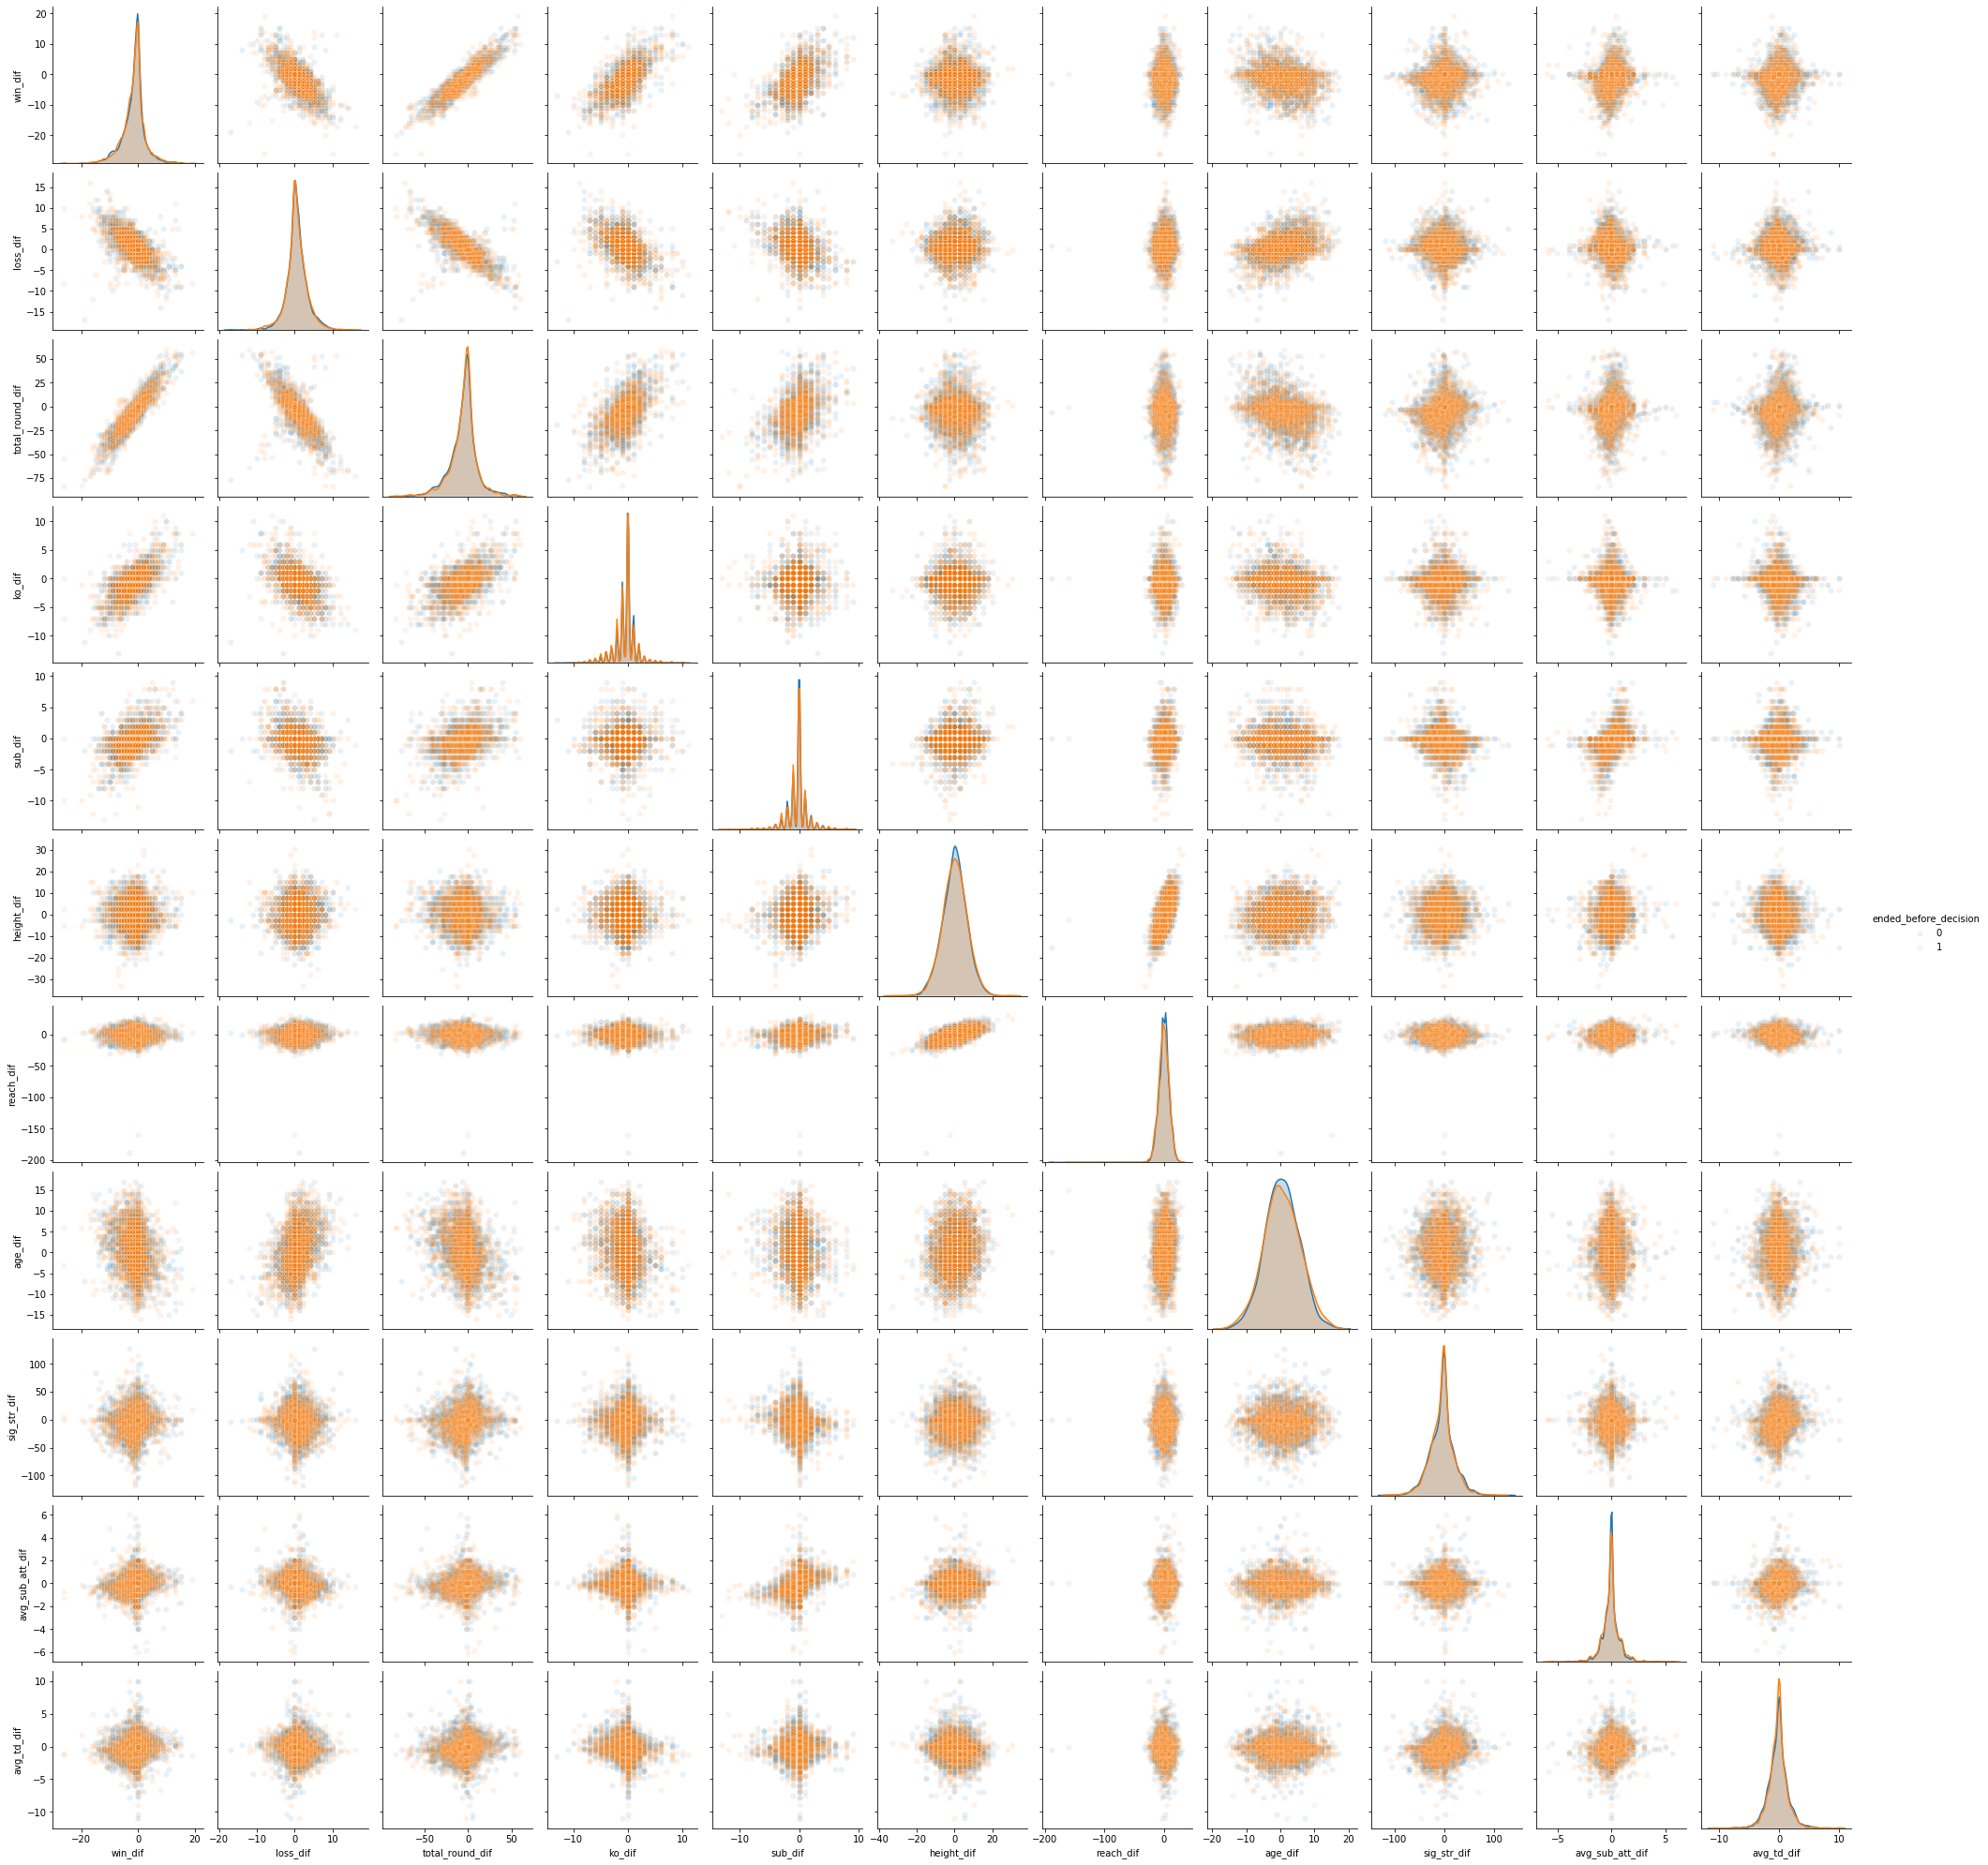

In [525]:
sub_df = df_finish[['win_dif', 'loss_dif', 'total_round_dif', 'ko_dif',
                   'sub_dif', 'height_dif', 'reach_dif', 'age_dif', 'sig_str_dif', 
                    'avg_sub_att_dif', 'avg_td_dif', 'ended_before_decision']]
sns.pairplot(sub_df, hue='ended_before_decision', plot_kws={'alpha': 0.1})

Nothing! I can not extract any patterns from this.

Just like answering previous question, I want to build the model and check importance it gives to features. Again, this will be a simple classification task.

In [526]:
y_finish = df_finish['ended_before_decision']
log_reg_coef, X_columns = train_model(df_finish, y_finish, cat_vars, num_vars_no_finish, 
                                      LogisticRegression())
coef_df = get_coef(log_reg_coef, X_columns)
coef_df.head(10)

0.5847665847665847


,column,coef,abs_coefs
3,B_ev,1.757601,1.757601
2,R_ev,1.562052,1.562052
16,B_total_rounds_fought,-1.194205,1.194205
38,R_total_rounds_fought,-1.107905,1.107905
5,no_of_rounds,0.962845,0.962845
34,R_avg_TD_landed,-0.886390,0.886390
33,R_avg_SUB_ATT,0.857680,0.857680
8,B_draw,-0.842640,0.842640
25,B_Height_cms,0.812951,0.812951
23,B_win_by_TKO_Doctor_Stoppage,0.766932,0.766932


And again odds (ev variables to be exact) are in top. As well as total round fought by both opponents. Is it because they have a lot of experience?

Number of round in the fight also seems to have affect.

In [527]:
print("Percentage of KO/TKO/SUB fights among 3-round bouts: {:.2f}%".format(df_finish[df_finish['no_of_rounds'] == 3][df_finish['ended_before_decision'] == 1].shape[0]/df_finish[df_finish['no_of_rounds'] == 3].shape[0]*100))
print("Percentage of KO/TKO/SUB fights among 5-round bouts: {:.2f}%".format(df_finish[df_finish['no_of_rounds'] == 5][df_finish['ended_before_decision'] == 1].shape[0]/df_finish[df_finish['no_of_rounds'] == 5].shape[0]*100))

Percentage of KO/TKO/SUB fights among 3-round bouts: 49.17%
Percentage of KO/TKO/SUB fights among 5-round bouts: 64.48%


Makes sense. 5 rounds are more tiring, fighters tend to finish it earlier.

To be honest I am not quite happy with the results, this is far from what I was ecpecting when I started working on this dataset. But again, bad result is also a result. Guess I am gonna have to watch every single match hoping for a knockout!